In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install klib

In [ ]:
# Data manipulation and preprocessing
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


# Statistical tests
from scipy.stats import chi2_contingency

# Machine learning models and metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

# Deep learning libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Model persistence
import pickle
import joblib

# Data visualization
import klib
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
traindata = pd.read_csv('/content/drive/MyDrive/playground-series-s3e22/train.csv')
testdata  = pd.read_csv('/content/drive/MyDrive/playground-series-s3e22/test.csv')
submissiondata = pd.read_csv('/content/drive/MyDrive/playground-series-s3e22/sample_submission.csv')



# Exploratory Data Analysis - EDA

In [ ]:
traindata

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,1230,yes,adult,535246,38.5,129.0,48.0,cool,reduced,pale_pink,...,57.0,66.0,serosanguious,2.0,yes,2206,0,0,no,lived
1231,1231,yes,adult,528570,37.5,60.0,50.0,cool,reduced,pale_cyanotic,...,35.0,6.4,serosanguious,3.6,yes,2209,0,0,yes,died
1232,1232,yes,young,529685,37.5,84.0,40.0,normal,reduced,normal_pink,...,40.0,5.9,cloudy,7.0,yes,400,0,0,yes,lived
1233,1233,yes,adult,534784,38.1,70.0,16.0,normal,reduced,bright_red,...,58.0,74.0,cloudy,2.0,yes,2209,0,0,no,lived


In [ ]:
klib.missingval_plot(traindata)

No missing values found in the dataset.


### *Removing unnecessary columns*

In [ ]:
traindata.drop(['id','hospital_number'],axis =1, inplace = True)
testdata.drop (['id','hospital_number'],axis =1, inplace = True)

In [ ]:
print(traindata.info())
print(testdata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   rectal_temp            1235 non-null   float64
 3   pulse                  1235 non-null   float64
 4   respiratory_rate       1235 non-null   float64
 5   temp_of_extremities    1235 non-null   object 
 6   peripheral_pulse       1235 non-null   object 
 7   mucous_membrane        1235 non-null   object 
 8   capillary_refill_time  1235 non-null   object 
 9   pain                   1235 non-null   object 
 10  peristalsis            1235 non-null   object 
 11  abdominal_distention   1235 non-null   object 
 12  nasogastric_tube       1235 non-null   object 
 13  nasogastric_reflux     1235 non-null   object 
 14  nasogastric_reflux_ph  1235 non-null   float64
 15  rect

#### *Regarding the columns of lesion_1, lesion_2 and lesion_3*

Since those are categorical variables, need to convert to object or category type variables

In [ ]:
lesion_columns = ['lesion_1', 'lesion_2', 'lesion_3']

def convert_int_to_object(data, columns):
    for column in columns:
        if data[column].dtype == 'int64':
            data[column] = data[column].astype('object')


convert_int_to_object(traindata, lesion_columns)
convert_int_to_object(testdata, lesion_columns)

In [ ]:
categorical_columns = traindata.select_dtypes(include=['object', 'category']).columns.tolist()
traindata[categorical_columns]

,surgery,age,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,yes,adult,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,decreased,distend_small,serosanguious,yes,2209,0,0,no,died
1,yes,adult,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,absent,distend_small,serosanguious,yes,2208,0,0,no,euthanized
2,yes,adult,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,None,distend_large,serosanguious,yes,5124,0,0,no,lived
3,yes,adult,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,decreased,distend_small,cloudy,yes,2208,0,0,yes,lived
4,no,adult,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,normal,normal,cloudy,no,0,0,0,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,yes,adult,cool,reduced,pale_pink,more_3_sec,depressed,absent,moderate,none,more_1_liter,None,distend_large,serosanguious,yes,2206,0,0,no,lived
1231,yes,adult,cool,reduced,pale_cyanotic,less_3_sec,mild_pain,hypomotile,slight,slight,none,decreased,distend_small,serosanguious,yes,2209,0,0,yes,died
1232,yes,young,normal,reduced,normal_pink,less_3_sec,mild_pain,hypomotile,slight,slight,none,increased,firm,cloudy,yes,400,0,0,yes,lived
1233,yes,adult,normal,reduced,bright_red,less_3_sec,mild_pain,hypomotile,slight,none,more_1_liter,absent,distend_small,cloudy,yes,2209,0,0,no,lived


In [ ]:
quantitative_columns = traindata.select_dtypes(include=['float64', 'int64', 'category']).columns.tolist()
traindata[quantitative_columns]

,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein
0,38.1,132.0,24.0,6.5,57.0,8.5,3.4
1,37.5,88.0,12.0,2.0,33.0,64.0,2.0
2,38.3,120.0,28.0,3.5,37.0,6.4,3.4
3,37.1,72.0,30.0,2.0,53.0,7.0,3.9
4,38.0,52.0,48.0,7.0,47.0,7.3,2.6
...,...,...,...,...,...,...,...
1230,38.5,129.0,48.0,2.0,57.0,66.0,2.0
1231,37.5,60.0,50.0,3.0,35.0,6.4,3.6
1232,37.5,84.0,40.0,3.0,40.0,5.9,7.0
1233,38.1,70.0,16.0,2.0,58.0,74.0,2.0


In [ ]:
traindata.info()
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   rectal_temp            1235 non-null   float64
 3   pulse                  1235 non-null   float64
 4   respiratory_rate       1235 non-null   float64
 5   temp_of_extremities    1235 non-null   object 
 6   peripheral_pulse       1235 non-null   object 
 7   mucous_membrane        1235 non-null   object 
 8   capillary_refill_time  1235 non-null   object 
 9   pain                   1235 non-null   object 
 10  peristalsis            1235 non-null   object 
 11  abdominal_distention   1235 non-null   object 
 12  nasogastric_tube       1235 non-null   object 
 13  nasogastric_reflux     1235 non-null   object 
 14  nasogastric_reflux_ph  1235 non-null   float64
 15  rect

In [ ]:
df = traindata

In [ ]:
categorical_columns = df.select_dtypes(include=['object']).columns

for column in categorical_columns[:-1]:
    print(column, testdata[column].unique())

surgery ['no' 'yes']
age ['adult' 'young']
temp_of_extremities ['normal' 'cool' 'None' 'cold' 'warm']
peripheral_pulse ['normal' 'reduced' 'None' 'absent' 'increased']
mucous_membrane ['normal_pink' 'bright_pink' 'bright_red' 'pale_cyanotic' 'dark_cyanotic'
 'pale_pink' 'None']
capillary_refill_time ['less_3_sec' 'more_3_sec' 'None' '3']
pain ['mild_pain' 'depressed' 'severe_pain' 'extreme_pain' 'None' 'moderate'
 'alert']
peristalsis ['hypomotile' 'absent' 'hypermotile' 'None' 'normal']
abdominal_distention ['slight' 'moderate' 'severe' 'none' 'None']
nasogastric_tube ['none' 'slight' 'None' 'significant']
nasogastric_reflux ['none' 'more_1_liter' 'less_1_liter' 'None']
rectal_exam_feces ['normal' 'decreased' 'absent' 'None' 'increased']
abdomen ['distend_small' 'distend_large' 'None' 'other' 'firm' 'normal']
abdomo_appearance ['clear' 'serosanguious' 'cloudy' 'None']
surgical_lesion ['no' 'yes']
lesion_1 [0 2208 2205 1400 2207 2209 4205 2124 3205 2112 2206 3111 5400 31110 400
 8400 2

## Univariate analysis

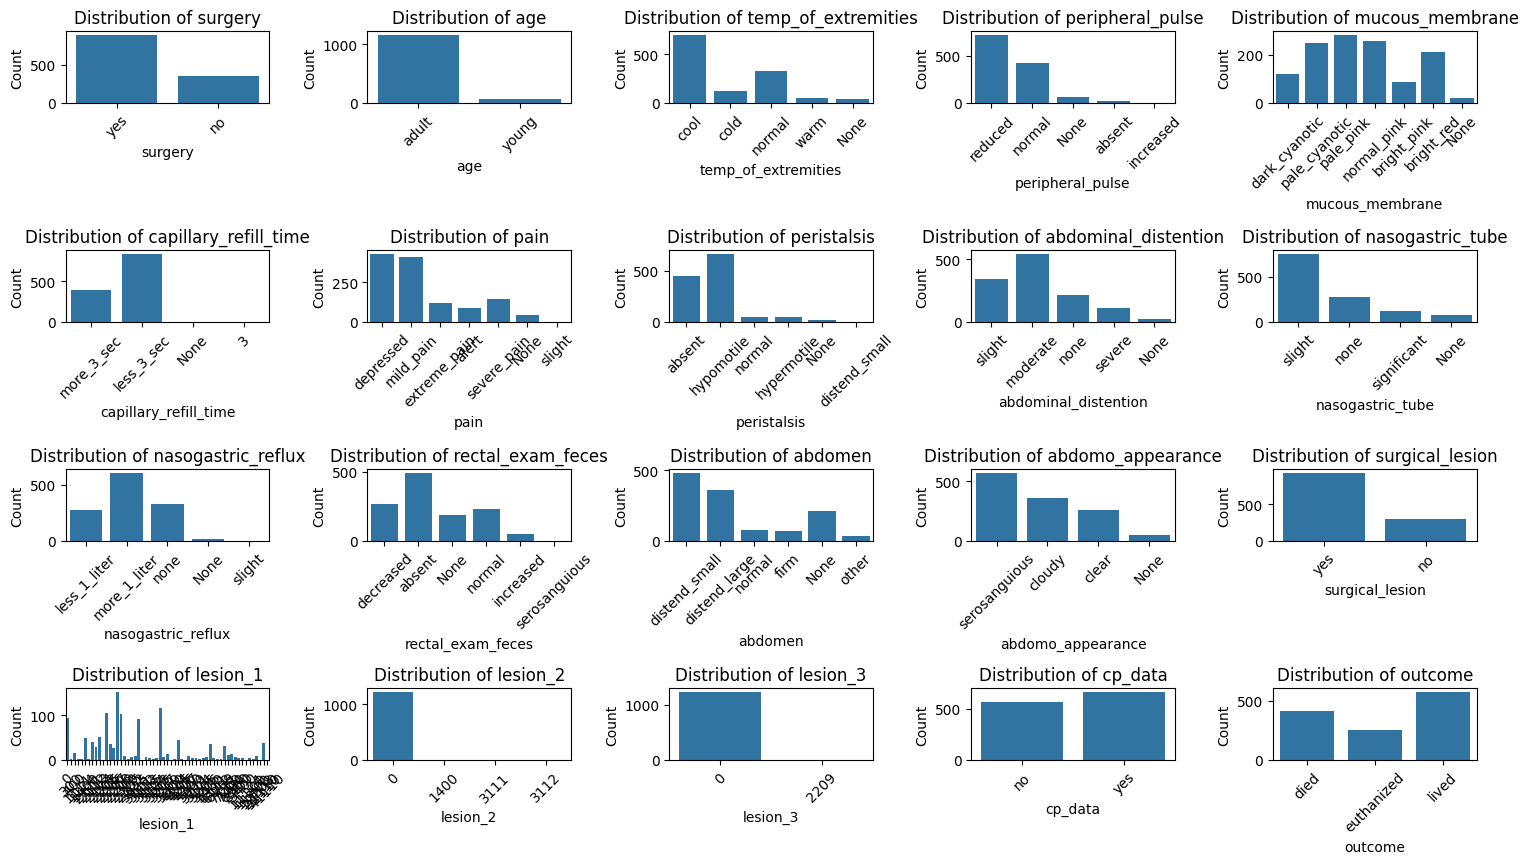

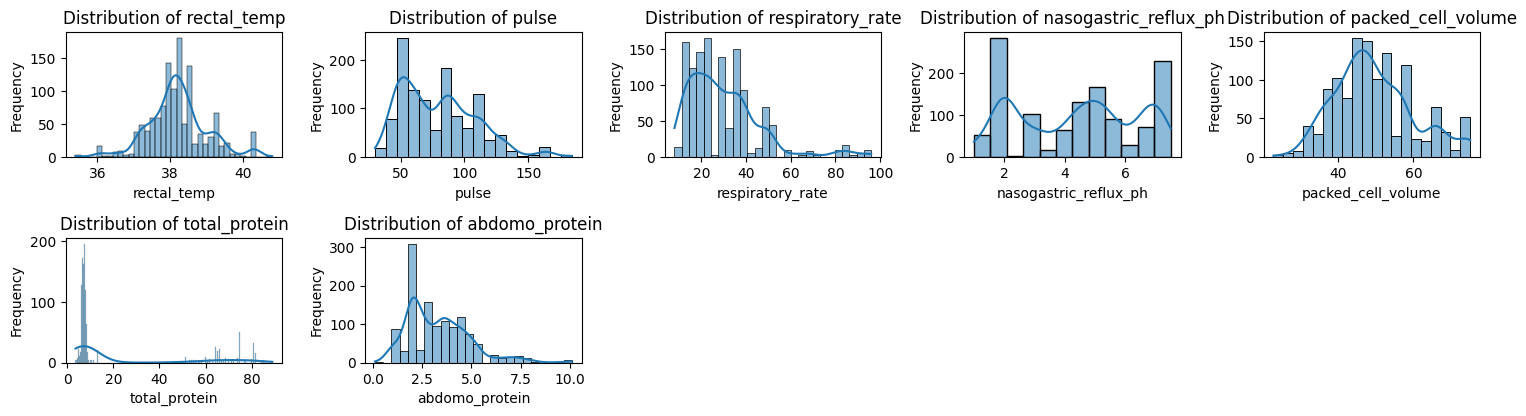

In [ ]:
# Define a function for univariate analysis of categorical variables
def univariate_categorical_analysis(data, column, ax):
    sns.countplot(data=data, x=column, ax=ax)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# Define a function for univariate analysis of numeric variables
def univariate_numeric_analysis(data, column, ax):
    sns.histplot(data=data, x=column, kde=True, ax=ax)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

num_rows = 5
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Univariate analysis for categorical variables
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
for i, column in enumerate(categorical_columns):
    row = i // num_cols
    col = i % num_cols
    univariate_categorical_analysis(df, column, ax=axes[row, col])

# Remove any unused subplots
for i in range(len(categorical_columns), num_rows*num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Adjust layout
plt.tight_layout()
plt.show()

# Set up the subplots grid for numeric variables
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Univariate analysis for numeric variables
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
for i, column in enumerate(numeric_columns):
    row = i // num_cols
    col = i % num_cols
    univariate_numeric_analysis(df, column, ax=axes[row, col])

# Remove any unused subplots
for i in range(len(numeric_columns), num_rows*num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Adjust layout
plt.tight_layout()
plt.show()

#### analysing the outcome variable class balance - dependent variable class balance

In [ ]:
df['outcome'].value_counts()

lived         574
died          410
euthanized    251
Name: outcome, dtype: int64

### seems to be ok, so dont need to balance the dataset.

## Bivariate analysis

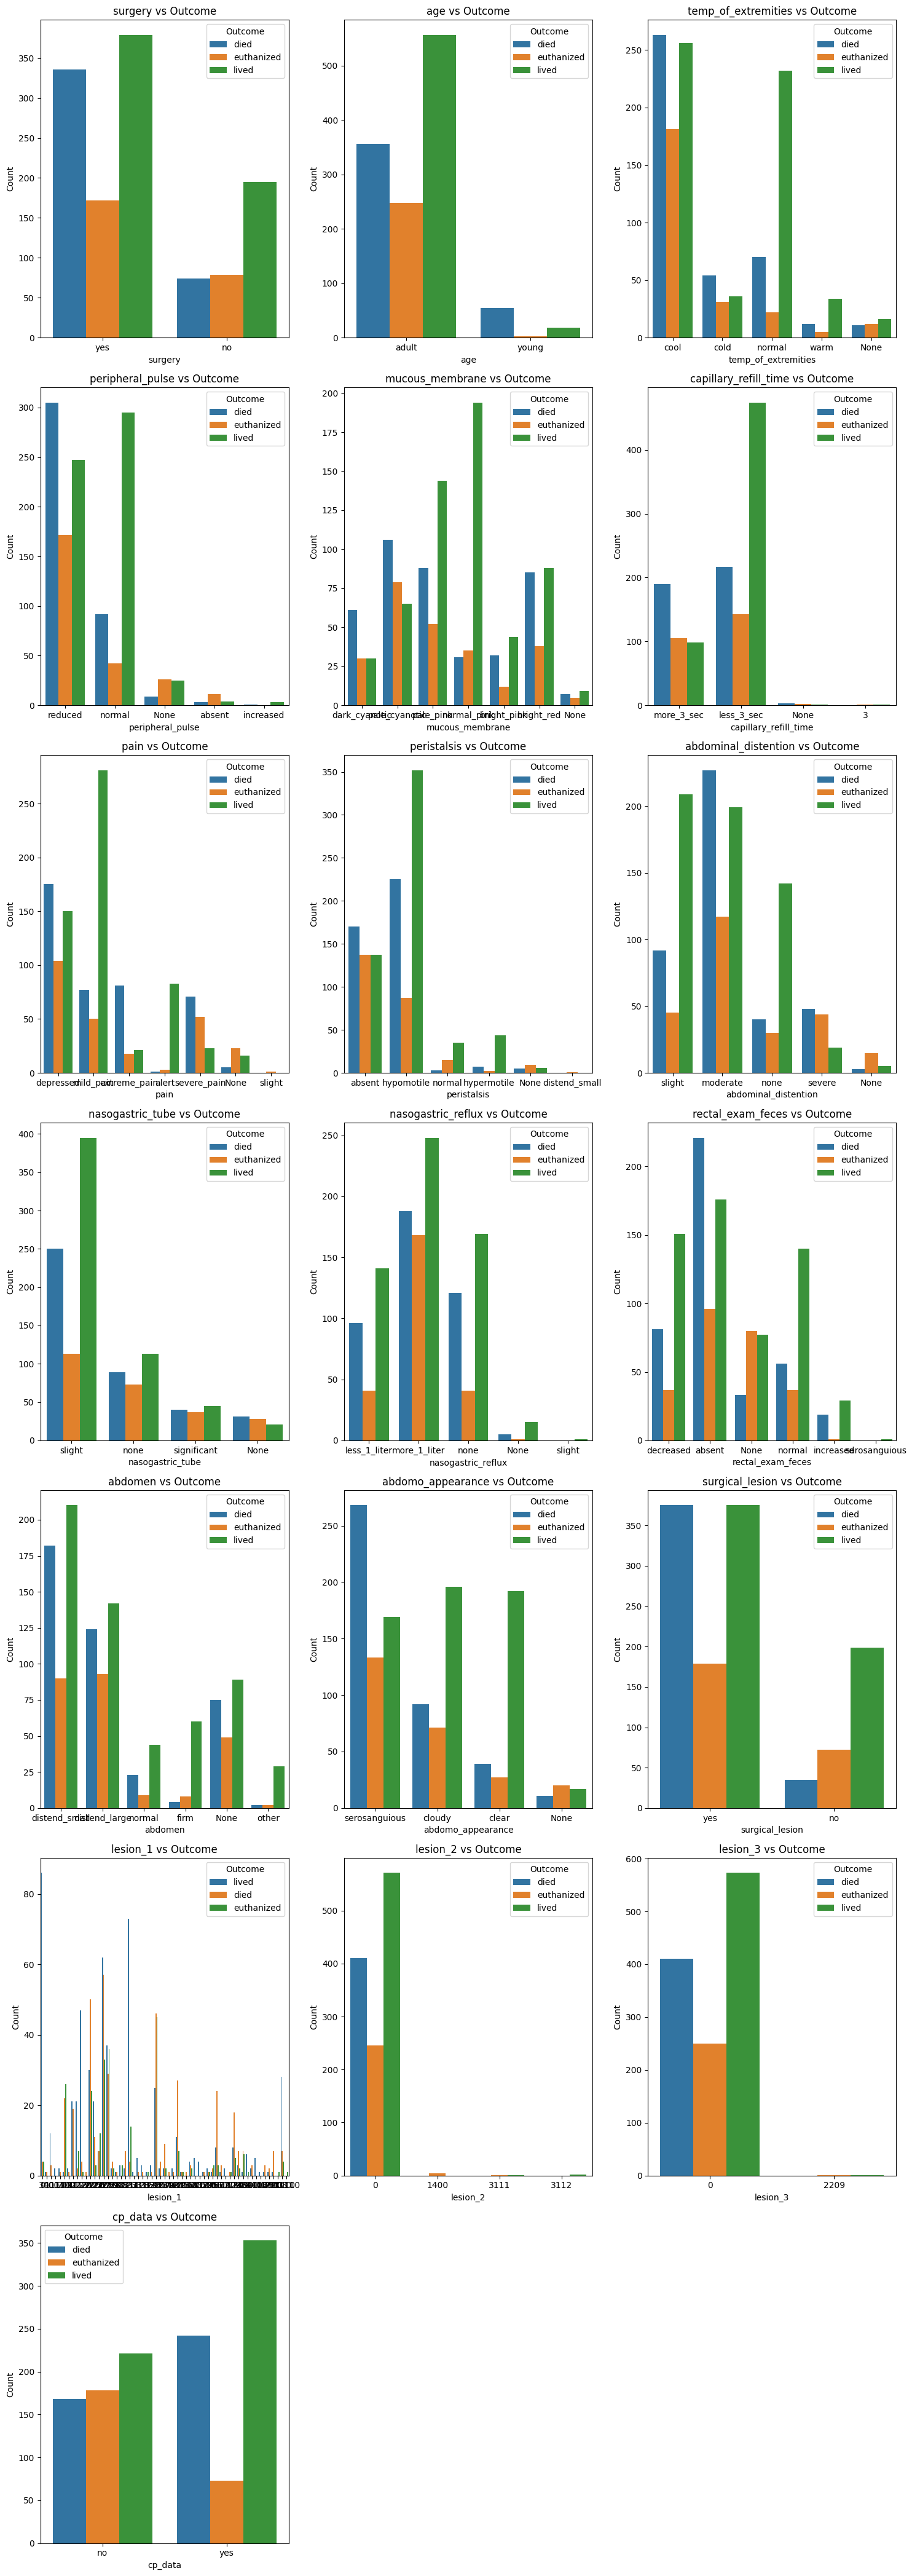

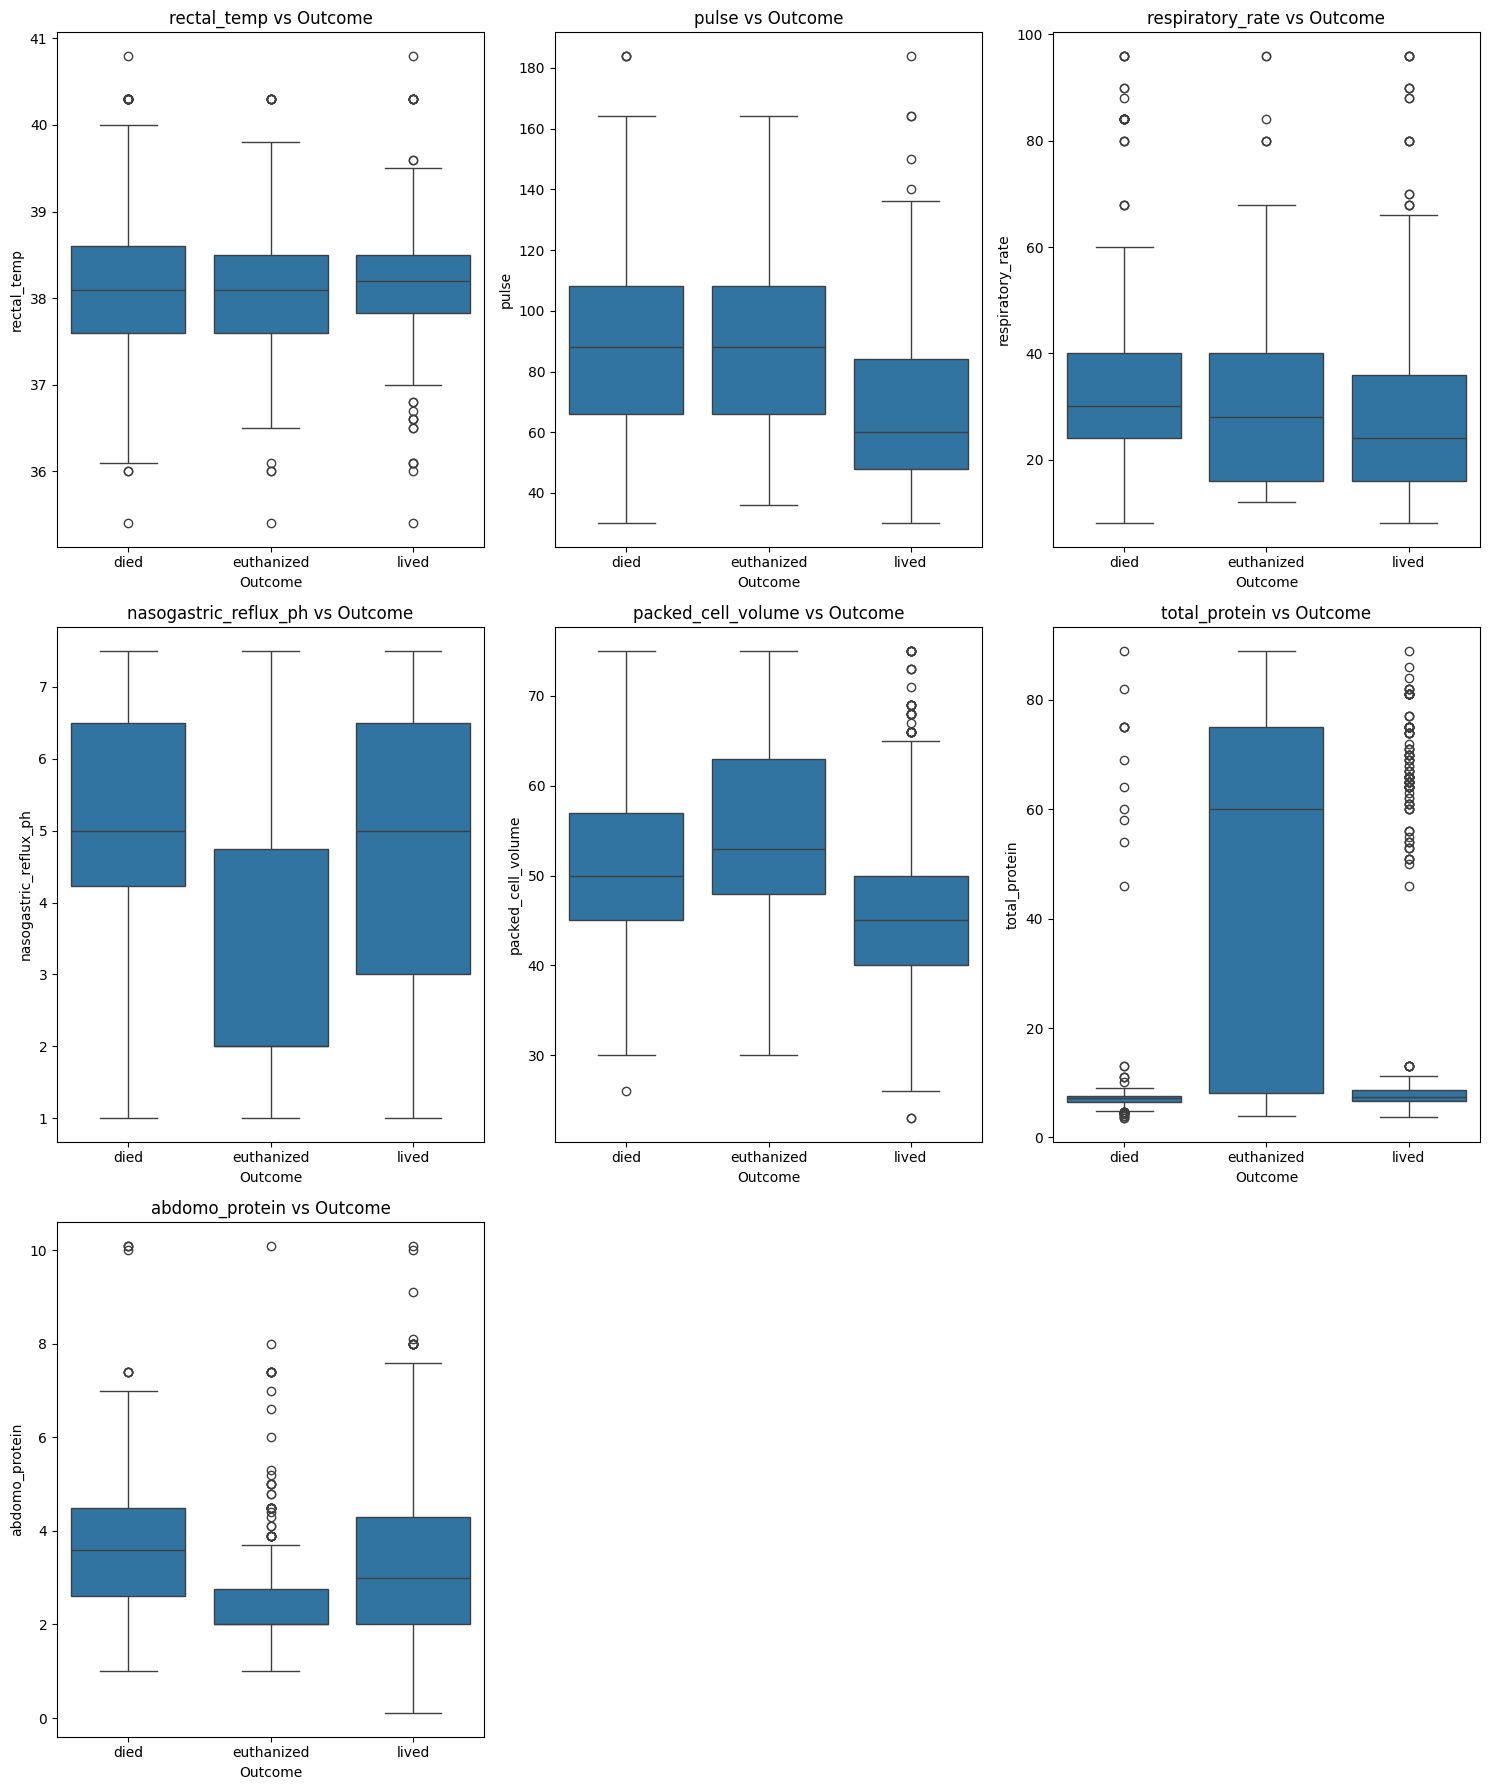

In [ ]:
# Define a function for bivariate analysis of categorical variables with 'outcome'
def bivariate_categorical_outcome_analysis(data, column, ax):
    sns.countplot(data=data, x=column, hue='outcome', ax=ax)
    ax.set_title(f'{column} vs Outcome')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.legend(title='Outcome')

# Define a function for bivariate analysis of numeric variables with 'outcome'
def bivariate_numeric_outcome_analysis(data, column, ax):
    sns.boxplot(data=data, x='outcome', y=column, ax=ax)
    ax.set_title(f'{column} vs Outcome')
    ax.set_xlabel('Outcome')
    ax.set_ylabel(column)

# Set up the subplots grid for categorical variables with 'outcome'
num_cols = 3
num_rows = (len(df.select_dtypes(include=['object', 'category']).columns) - 1) // num_cols + 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))

# Bivariate analysis for categorical variables with 'outcome'
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
for i, column in enumerate(categorical_columns):
    if column != 'outcome':
        row = i // num_cols
        col = i % num_cols
        bivariate_categorical_outcome_analysis(df, column, ax=axes[row, col])

# Remove any unused subplots
for i in range(len(categorical_columns)-1, num_rows*num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Adjust layout
plt.tight_layout()
plt.show()

# Set up the subplots grid for numeric variables with 'outcome'
num_cols = 3
num_rows = (len(df.select_dtypes(include=['float64', 'int64']).columns)) // num_cols + 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))

# Bivariate analysis for numeric variables with 'outcome'
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
for i, column in enumerate(numeric_columns):
    row = i // num_cols
    col = i % num_cols
    bivariate_numeric_outcome_analysis(df, column, ax=axes[row, col])

# Remove any unused subplots
for i in range(len(numeric_columns), num_rows*num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Adjust layout
plt.tight_layout()
plt.show()

## Multivariate analysis

<Axes: title={'center': 'Feature-correlation (pearson)'}>

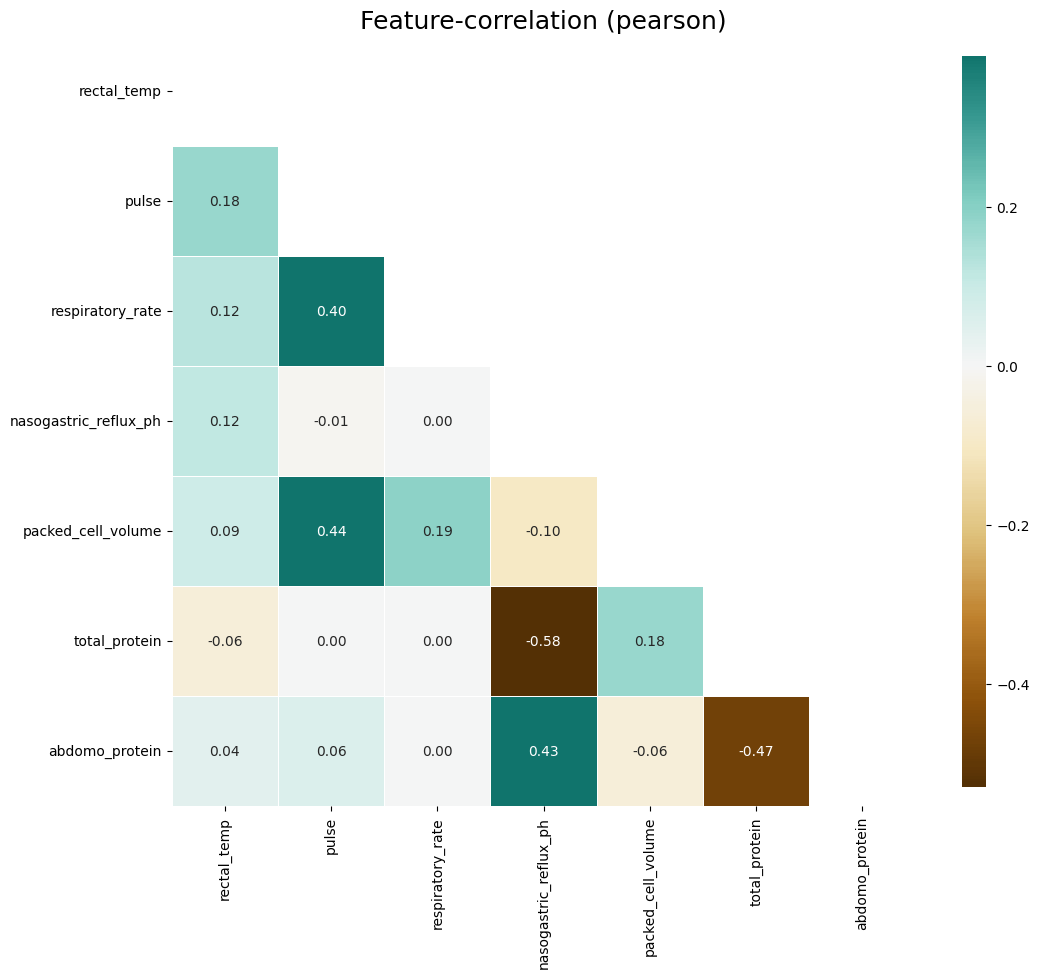

In [ ]:
klib.corr_plot(df)

#### *There is a considerable negative correlation between total_protein variable and nasogastic_reflux_ph variables. And also there is a positive correlation between abdomo_protein and nasogastic_reflux_ph variables.*

#### *Also there can be seen some negative correlation of total_protein with abdomo_protein.*

#### *Respiratory rate and pulse variables have a positive correlation of 0.4*

#### **So when doing advance analysis or model building we need to focus of those correlation variables. if needed we must omit the correlated variables.**

### *Test of association for categorical variables*

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Load the dataset
data = df  # Replace 'your_dataset.csv' with the path to your dataset

# Drop rows with missing values
data.dropna(inplace=True)

# Select only categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns

# Create an empty DataFrame to store the p-values
p_values = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

# Compute p-values for all pairs of categorical variables
for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 != col2:
            contingency_table = pd.crosstab(data[col1], data[col2])
            _, p_value, _, _ = chi2_contingency(contingency_table)
            p_values.loc[col1, col2] = p_value

# Function to highlight significant p-values
def highlight_significant(val):
    color = 'background-color: pink' if float(val) < 0.05 else ''
    return color

# Apply formatting to p-values DataFrame
formatted_p_values = p_values.style.applymap(highlight_significant)

# Display the formatted p-values
print("p-values with significant cells highlighted:")
formatted_p_values

p-values with significant cells highlighted:


,surgery,age,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
surgery,nan,0.078940,0.000000,0.000000,0.000000,0.080710,0.000000,0.000000,0.000000,0.207844,0.002091,0.000000,0.000000,0.000000,0.000000,0.000000,0.116346,0.920353,0.000000,0.000000
age,0.078940,nan,0.097053,0.264076,0.000044,0.072287,0.001872,0.675392,0.003019,0.295050,0.773488,0.006813,0.000000,0.192151,0.005391,0.000000,0.914340,1.000000,0.008948,0.000000
temp_of_extremities,0.000000,0.097053,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000160,0.000000,0.000000,0.000000,0.000000,0.000000,0.644199,0.821127,0.000021,0.000000
peripheral_pulse,0.000000,0.264076,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003326,0.000000,0.000000,0.000000,0.000000,0.000000,0.998869,0.841777,0.000000,0.000000
mucous_membrane,0.000000,0.000044,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.567002,0.277135,0.000005,0.000000
capillary_refill_time,0.080710,0.072287,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.023579,0.000055,0.000030,0.000000,0.000000,0.000000,0.990648,0.810158,0.000023,0.000000
pain,0.000000,0.001872,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.789294,0.987281,0.000000,0.000000
peristalsis,0.000000,0.675392,0.000000,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.571707,0.612997,0.000000,0.000000
abdominal_distention,0.000000,0.003019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000043,0.000000,0.000000,0.000000,0.000000,0.000000,0.028436,0.635182,0.000011,0.000000
nasogastric_tube,0.207844,0.295050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000000,nan,0.000000,0.000104,0.000006,0.131700,0.657442,0.001075,0.372926,0.786298,0.000119,0.000000


# Advanced analysis - ML model building

In [ ]:
data

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,yes,adult,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,yes,adult,38.5,129.0,48.0,cool,reduced,pale_pink,more_3_sec,depressed,...,57.0,66.0,serosanguious,2.0,yes,2206,0,0,no,lived
1231,yes,adult,37.5,60.0,50.0,cool,reduced,pale_cyanotic,less_3_sec,mild_pain,...,35.0,6.4,serosanguious,3.6,yes,2209,0,0,yes,died
1232,yes,young,37.5,84.0,40.0,normal,reduced,normal_pink,less_3_sec,mild_pain,...,40.0,5.9,cloudy,7.0,yes,400,0,0,yes,lived
1233,yes,adult,38.1,70.0,16.0,normal,reduced,bright_red,less_3_sec,mild_pain,...,58.0,74.0,cloudy,2.0,yes,2209,0,0,no,lived


## SVM model

#### with hyperparameter optimization  - may takes lots of time

In [ ]:
# # Load the dataset
# data = df

# # Drop rows with missing values
# data.dropna(inplace=True)

# # Convert categorical variables to numerical using LabelEncoder
# label_encoders = {}
# for column in data.select_dtypes(include=['object']).columns:
#     label_encoders[column] = LabelEncoder()
#     data[column] = label_encoders[column].fit_transform(data[column])

# # Split data into features and target variable
# X = data.drop('outcome', axis=1)
# y = data['outcome']

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'poly'],
#     'gamma': ['scale', 'auto']
# }

# # Instantiate the GridSearchCV object
# grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')

# # Fit the GridSearchCV object to the training data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and the best estimator
# best_params = grid_search.best_params_
# best_estimator_svm = grid_search.best_estimator_

# # Train the best estimator on the full training set
# best_estimator_svm.fit(X_train, y_train)

# # Make predictions on the testing set using the best estimator
# y_pred = best_estimator_svm.predict(X_test)

# # Evaluate the model
# accuracy_svm = accuracy_score(y_test, y_pred)
# f1_svm = f1_score(y_test, y_pred, average='weighted')

# print("Best Parameters:", best_params)
# print("Accuracy:", accuracy_svm)
# print("F1-Score:", f1_svm)
# print("Classification Report:")
# print(classification_report(y_test, y_pred))

# # Create a confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Plot heatmap
# plt.figure(figsize=(5, 5))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()


#### Without hyper parameter optimization

Accuracy: 0.6275303643724697
F1-Score: 0.6294717114790555
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.69      0.58        72
           1       0.70      0.48      0.57        54
           2       0.72      0.65      0.68       121

    accuracy                           0.63       247
   macro avg       0.64      0.61      0.61       247
weighted avg       0.65      0.63      0.63       247



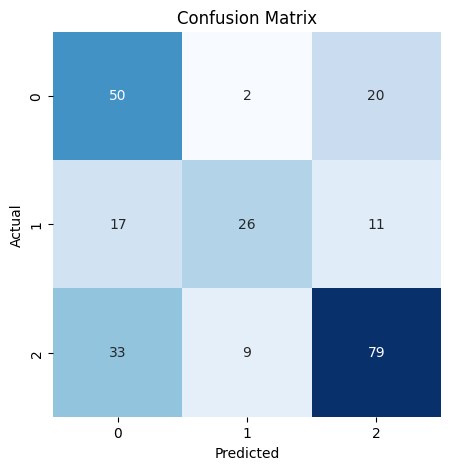

In [ ]:
# Load the dataset
data = df

# Drop rows with missing values
data.dropna(inplace=True)

# Convert categorical variables to numerical using LabelEncoder
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Split data into features and target variable
X = data.drop('outcome', axis=1)
y = data['outcome']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred)
f1_svm = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy_svm)
print("F1-Score:",f1_svm)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Logistic model

### with hyper parameter optimization

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy: 0.6356275303643725
F1-Score: 0.6360339460756037
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.65      0.58        72
           1       0.68      0.50      0.57        54
           2       0.70      0.69      0.69       121

    accuracy                           0.64       247
   macro avg       0.64      0.61      0.62       247
weighted avg       0.65      0.64      0.64       247



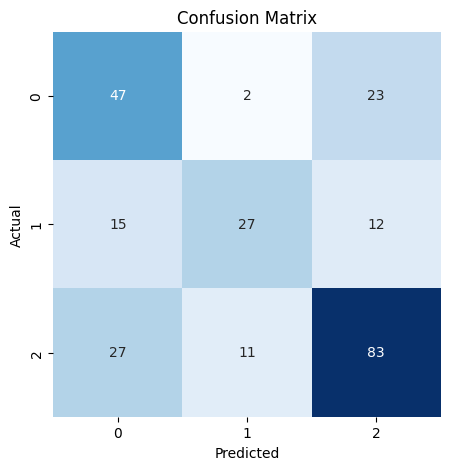

In [ ]:
# Load the dataset
data = df

# Drop rows with missing values
data.dropna(inplace=True)

# Separate features and target variable
X = data.drop('outcome', axis=1)
y = data['outcome']

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Apply one-hot encoding to categorical columns
transformer = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), categorical_columns)], remainder='passthrough')
X_encoded = transformer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


# Define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator_logistic = grid_search.best_estimator_

# Train the best estimator on the full training set
best_estimator_logistic.fit(X_train, y_train)

# Make predictions on the testing set using the best estimator
y_pred = best_estimator_logistic.predict(X_test)

# Evaluate the model
accuracy_logistic = accuracy_score(y_test, y_pred)
f1_logistic = f1_score(y_test, y_pred, average='weighted')

print("Best Parameters:", best_params)
print("Accuracy:", accuracy_logistic)
print("F1-Score:", f1_logistic)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Random Forest model

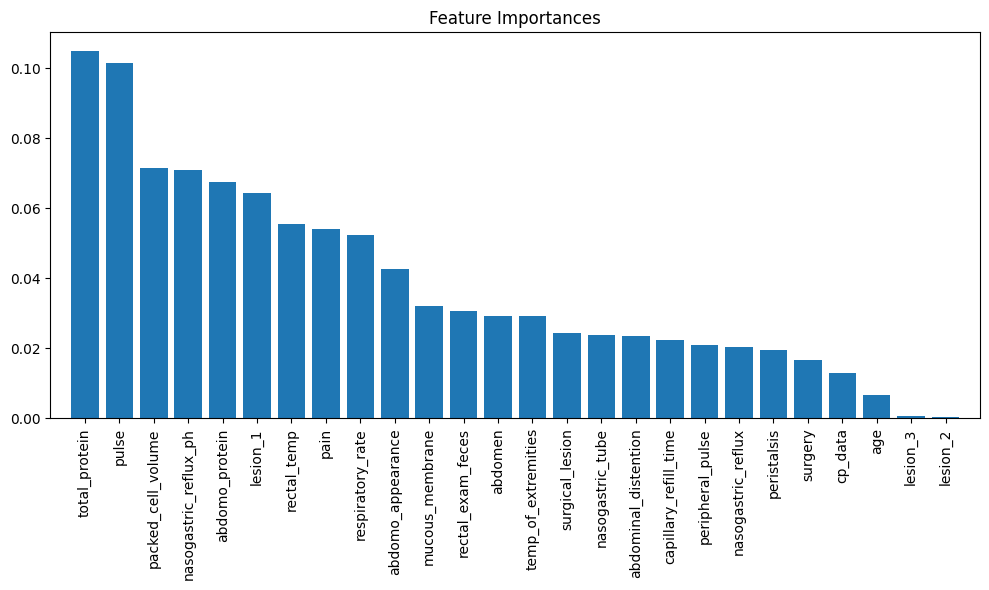

Accuracy: 0.7004048582995951
F1-Score: 0.7021325733030279
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.71      0.64        72
           1       0.77      0.61      0.68        54
           2       0.76      0.74      0.75       121

    accuracy                           0.70       247
   macro avg       0.70      0.68      0.69       247
weighted avg       0.71      0.70      0.70       247



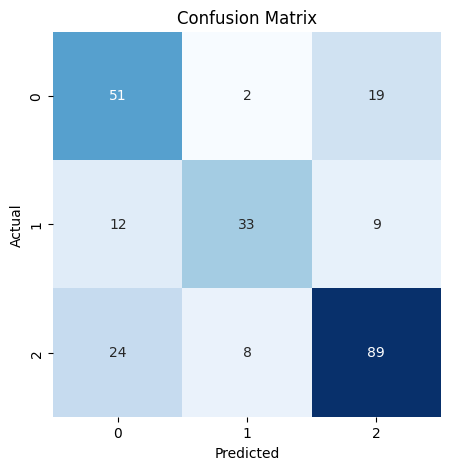

In [ ]:
# Load the dataset
data = df.copy()

# Drop rows with missing values
data.dropna(inplace=True)

# Convert categorical variables to numerical using LabelEncoder
label_encoders_rf = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders_rf[column] = LabelEncoder()
    data[column] = label_encoders_rf[column].fit_transform(data[column])

# Split data into features and target variable
X = data.drop('outcome', axis=1)
y = data['outcome']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_model.predict(X_test)


# Get feature importances
importances = rf_model.feature_importances_
features = X.columns

# Sort feature importances in descending order
indices = importances.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

accuracy_rf = accuracy_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy_rf)
print("F1-Score:",f1_rf)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### *feature selection for random forest* - Reduced model

#### threashold is 0.02

Accuracy: 0.6720647773279352
F1-Score: 0.6743361131248434
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.72      0.63        72
           1       0.74      0.57      0.65        54
           2       0.75      0.69      0.72       121

    accuracy                           0.67       247
   macro avg       0.68      0.66      0.66       247
weighted avg       0.69      0.67      0.67       247



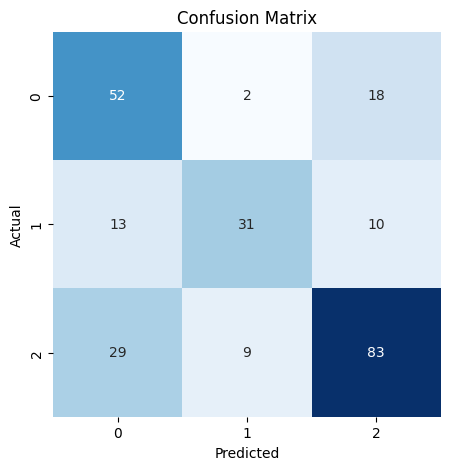

In [ ]:
selected_features = features[importances > 0.02]

# Split data into features and target variable
X = data[selected_features]
y = data['outcome']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_reduced.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_model_reduced.predict(X_test)


accuracy_rf_reduced_model = accuracy_score(y_test, y_pred)
f1_rf_reduced_model = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy_rf_reduced_model)
print("F1-Score:",f1_rf_reduced_model)
print("Classification Report:")
print(classification_report(y_test, y_pred))


# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
! pip install xgboost

## XGBoost model

### with hyper parameter optimization


In [ ]:
# # Load the dataset
# data = df

# # Drop rows with missing values
# data.dropna(inplace=True)

# # Convert categorical variables to numerical using LabelEncoder
# label_encoders_xgb = {}
# for column in data.select_dtypes(include=['object']).columns:
#     label_encoders_xgb[column] = LabelEncoder()
#     data[column] = label_encoders_xgb[column].fit_transform(data[column])

# # Split data into features and target variable
# X = data.drop('outcome', axis=1)
# y = data['outcome']

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the parameter grid
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.1, 0.01],
#     'n_estimators': [100, 200, 300],
#     'min_child_weight': [1, 3, 5],
#     'gamma': [0, 0.1, 0.2]

# }

# # Instantiate the GridSearchCV object
# grid_search = GridSearchCV(XGBClassifier(objective='multi:softmax', num_class=len(set(y)), random_state=42),
#                            param_grid,
#                            cv=5,
#                            scoring='accuracy')

# # Fit the GridSearchCV object to the training data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and the best estimator
# best_params = grid_search.best_params_
# best_estimator_xgb = grid_search.best_estimator_

# # Train the best estimator on the full training set
# best_estimator_xgb.fit(X_train, y_train)

# # Make predictions on the testing set using the best estimator
# y_pred = best_estimator_xgb.predict(X_test)

# # Evaluate the model
# accuracy_xgb = accuracy_score(y_test, y_pred)
# f1_xgb = f1_score(y_test, y_pred, average='weighted')

# print("Best Parameters:", best_params)
# print("Accuracy:", accuracy_xgb)
# print("F1-Score:", f1_xgb)
# print("Classification Report:")
# print(classification_report(y_test, y_pred))

# # Create a confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Plot heatmap
# plt.figure(figsize=(5, 5))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()


### without hyper parameter optimization

Accuracy: 0.7044534412955465
F1-Score: 0.7062194956019678
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.69      0.65        72
           1       0.78      0.67      0.72        54
           2       0.75      0.73      0.74       121

    accuracy                           0.70       247
   macro avg       0.71      0.70      0.70       247
weighted avg       0.71      0.70      0.71       247



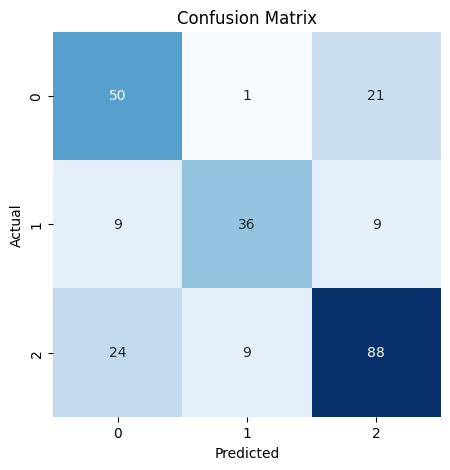

In [ ]:
# Load the dataset
data = df

# Drop rows with missing values
data.dropna(inplace=True)

# Convert categorical variables to numerical using LabelEncoder
label_encoders_xgb = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders_xgb[column] = LabelEncoder()
    data[column] = label_encoders_xgb[column].fit_transform(data[column])

# Split data into features and target variable
X = data.drop('outcome', axis=1)
y = data['outcome']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(set(y)), random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = xgb_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy_xgb)
print("F1-Score:",f1_xgb)
print("Classification Report:")
print(classification_report(y_test, y_pred))


# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   int64  
 1   age                    1235 non-null   int64  
 2   rectal_temp            1235 non-null   float64
 3   pulse                  1235 non-null   float64
 4   respiratory_rate       1235 non-null   float64
 5   temp_of_extremities    1235 non-null   int64  
 6   peripheral_pulse       1235 non-null   int64  
 7   mucous_membrane        1235 non-null   int64  
 8   capillary_refill_time  1235 non-null   int64  
 9   pain                   1235 non-null   int64  
 10  peristalsis            1235 non-null   int64  
 11  abdominal_distention   1235 non-null   int64  
 12  nasogastric_tube       1235 non-null   int64  
 13  nasogastric_reflux     1235 non-null   int64  
 14  nasogastric_reflux_ph  1235 non-null   float64
 15  rect

In [ ]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                824 non-null    object 
 1   age                    824 non-null    object 
 2   rectal_temp            824 non-null    float64
 3   pulse                  824 non-null    float64
 4   respiratory_rate       824 non-null    float64
 5   temp_of_extremities    824 non-null    object 
 6   peripheral_pulse       824 non-null    object 
 7   mucous_membrane        824 non-null    object 
 8   capillary_refill_time  824 non-null    object 
 9   pain                   824 non-null    object 
 10  peristalsis            824 non-null    object 
 11  abdominal_distention   824 non-null    object 
 12  nasogastric_tube       824 non-null    object 
 13  nasogastric_reflux     824 non-null    object 
 14  nasogastric_reflux_ph  824 non-null    float64
 15  rectal

## Neural Network model

Epoch 1/10
14/14 [==============================] - 4s 43ms/step - loss: 3.0637 - accuracy: 0.4308 - val_loss: 1.5513 - val_accuracy: 0.4646
Epoch 2/10
14/14 [==============================] - 0s 12ms/step - loss: 1.2504 - accuracy: 0.5039 - val_loss: 1.1592 - val_accuracy: 0.5152
Epoch 3/10
14/14 [==============================] - 0s 10ms/step - loss: 1.0129 - accuracy: 0.5602 - val_loss: 1.0795 - val_accuracy: 0.5556
Epoch 4/10
14/14 [==============================] - 0s 8ms/step - loss: 0.8963 - accuracy: 0.5939 - val_loss: 0.9743 - val_accuracy: 0.5657
Epoch 5/10
14/14 [==============================] - 0s 10ms/step - loss: 0.8624 - accuracy: 0.6130 - val_loss: 0.9575 - val_accuracy: 0.5859
Epoch 6/10
14/14 [==============================] - 0s 7ms/step - loss: 0.8609 - accuracy: 0.6029 - val_loss: 0.9960 - val_accuracy: 0.5455
Epoch 7/10
14/14 [==============================] - 0s 23ms/step - loss: 0.8449 - accuracy: 0.6130 - val_loss: 0.9511 - val_accuracy: 0.5657
Epoch 8/10
14/1

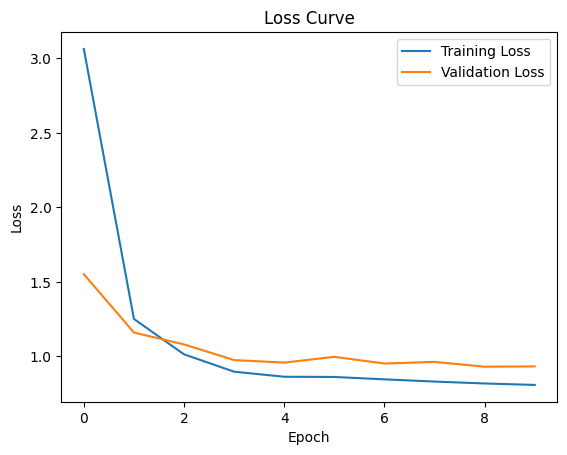

8/8 [==============================] - 0s 7ms/step - loss: 0.8520 - accuracy: 0.6032
Accuracy: 0.6032388806343079
8/8 [==============================] - 1s 10ms/step
F1 Score: 0.6029663901655488


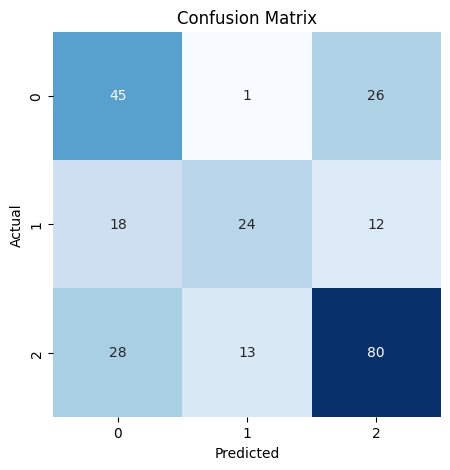

In [ ]:
# Load the dataset
data = df.copy()

# Drop rows with missing values
data.dropna(inplace=True)

# Convert categorical variables to numerical using LabelEncoder
label_encoders_nn = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders_nn[column] = LabelEncoder()
    data[column] = label_encoders_nn[column].fit_transform(data[column])

# Split data into features and target variable
X = data.drop('outcome', axis=1)
y = data['outcome']

# Convert target variable to categorical
y_categorical = to_categorical(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Build the neural network model
NNmodel = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(len(set(y)), activation='softmax')
])

# Compile the model
NNmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = NNmodel.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)

# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Evaluate the model
_, accuracy_nm = NNmodel.evaluate(X_test, y_test)
print("Accuracy:", accuracy_nm)

# Make predictions on the testing set
y_pred = NNmodel.predict(X_test)
y_pred_classes = [round(pred.argmax()) for pred in y_pred]

# Calculate F1 score
f1_nm = classification_report(y_test.argmax(axis=1), y_pred_classes, output_dict=True)['weighted avg']['f1-score']
print("F1 Score:", f1_nm)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_classes)

# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## **Model evaluation for best model**

In [ ]:
accuracy = [accuracy_svm, accuracy_logistic, accuracy_rf, accuracy_rf_reduced_model, accuracy_xgb, accuracy_nm]
f1_score = [f1_svm, f1_logistic, f1_rf, f1_rf_reduced_model, f1_xgb, f1_nm]

Models = ["SVM", "Logistic", "Random Forest", "Random Forest - Reduced", "XGBoost", "Neural Network-sq"]

model_table = pd.DataFrame({"Model": Models, "Accuracy": accuracy, "F1-Score": f1_score})

# Find the index of the row with the maximum F1-score
best_model_index = model_table["F1-Score"].idxmax()

# Create a new DataFrame with the best model highlighted
highlighted_model_table = model_table.style.apply(lambda x: ["background: lightgreen" if x.name == best_model_index else "" for i in x], axis=1)

highlighted_model_table

,Model,Accuracy,F1-Score
0,SVM,0.627530,0.629472
1,Logistic,0.635628,0.636034
2,Random Forest,0.700405,0.702133
3,Random Forest - Reduced,0.672065,0.674336
4,XGBoost,0.704453,0.706219
5,Neural Network-sq,0.603239,0.602966


### ***Saving the model***

In [ ]:
label_encoders

{'surgery': LabelEncoder(),
 'age': LabelEncoder(),
 'temp_of_extremities': LabelEncoder(),
 'peripheral_pulse': LabelEncoder(),
 'mucous_membrane': LabelEncoder(),
 'capillary_refill_time': LabelEncoder(),
 'pain': LabelEncoder(),
 'peristalsis': LabelEncoder(),
 'abdominal_distention': LabelEncoder(),
 'nasogastric_tube': LabelEncoder(),
 'nasogastric_reflux': LabelEncoder(),
 'rectal_exam_feces': LabelEncoder(),
 'abdomen': LabelEncoder(),
 'abdomo_appearance': LabelEncoder(),
 'surgical_lesion': LabelEncoder(),
 'lesion_1': LabelEncoder(),
 'lesion_2': LabelEncoder(),
 'lesion_3': LabelEncoder(),
 'cp_data': LabelEncoder(),
 'outcome': LabelEncoder()}

In [ ]:
# Save the label encoders
joblib.dump(label_encoders, "label_encoders.pkl")
print("label_encoders saved successfully as", "encoded")


# Save the trained model to a file
filename = 'xgboost_model.pkl'
pickle.dump(xgb_model, open(filename, 'wb'))

print("XGBoost model saved successfully as", filename)

label_encoders saved successfully as encoded
XGBoost model saved successfully as xgboost_model.pkl


# Making predictions for new test data

# getting predictions using XGboost model

In [ ]:
lesion_columns = ['lesion_1', 'lesion_2', 'lesion_3']

for column in lesion_columns:
    if testdata[column].dtype == 'int64':
        testdata[column] = testdata[column].astype('object')

# Label encode categorical variables
label_encoders = {}  # Store label encoders for each categorical column
categorical_columns = testdata.select_dtypes(include=['object']).columns
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    testdata[column] = label_encoders[column].fit_transform(testdata[column])

# Make predictions on the preprocessed testdata
predictions = xgb_model.predict(testdata)
#predictions = best_estimator_xgb.predict(testdata)


# Map numerical predictions to their original labels
prediction_labels = {0: 'died', 1: 'euthanized', 2: 'lived'}

# Convert numerical predictions to their corresponding labels
original_predictions_labels = [prediction_labels[prediction] for prediction in predictions]

# Print the original predictions
print(original_predictions_labels)

['lived', 'lived', 'lived', 'euthanized', 'lived', 'died', 'lived', 'died', 'lived', 'lived', 'died', 'lived', 'lived', 'lived', 'lived', 'lived', 'lived', 'died', 'died', 'died', 'died', 'died', 'died', 'lived', 'lived', 'lived', 'lived', 'euthanized', 'lived', 'died', 'lived', 'died', 'died', 'lived', 'lived', 'died', 'died', 'lived', 'died', 'lived', 'died', 'euthanized', 'died', 'euthanized', 'lived', 'died', 'died', 'lived', 'died', 'lived', 'died', 'lived', 'lived', 'died', 'lived', 'lived', 'died', 'died', 'died', 'died', 'died', 'euthanized', 'lived', 'lived', 'died', 'lived', 'euthanized', 'died', 'lived', 'lived', 'died', 'lived', 'lived', 'lived', 'euthanized', 'died', 'euthanized', 'died', 'died', 'euthanized', 'died', 'lived', 'lived', 'euthanized', 'lived', 'lived', 'lived', 'euthanized', 'lived', 'lived', 'lived', 'lived', 'died', 'euthanized', 'euthanized', 'euthanized', 'died', 'died', 'died', 'died', 'died', 'lived', 'lived', 'lived', 'lived', 'lived', 'died', 'died',

## Preparing submission dataset

In [ ]:
submissiondata['outcome'] = original_predictions_labels

In [ ]:
submissiondata.to_csv('submission.csv')
submissiondata

,id,outcome
0,1235,lived
1,1236,lived
2,1237,lived
3,1238,euthanized
4,1239,lived
...,...,...
819,2054,died
820,2055,euthanized
821,2056,lived
822,2057,lived


# getting predictions using SVM model

In [ ]:
lesion_columns = ['lesion_1', 'lesion_2', 'lesion_3']

for column in lesion_columns:
    if testdata[column].dtype == 'int64':
        testdata[column] = testdata[column].astype('object')

# Label encode categorical variables
label_encoders = {}  # Store label encoders for each categorical column
categorical_columns = testdata.select_dtypes(include=['object']).columns
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    testdata[column] = label_encoders[column].fit_transform(testdata[column])

# Make predictions on the preprocessed testdata
predictions = svm_model.predict(testdata)
#predictions = best_estimator_svm.predict(testdata)

# Map numerical predictions to their original labels
prediction_labels = {0: 'died', 1: 'euthanized', 2: 'lived'}

# Convert numerical predictions to their corresponding labels
original_predictions_labels = [prediction_labels[prediction] for prediction in predictions]

# Print the original predictions
print(original_predictions_labels)


submissiondata['outcome'] = original_predictions_labels
submissiondata.to_csv('submission-svm.csv')


['lived', 'lived', 'lived', 'euthanized', 'lived', 'died', 'died', 'died', 'died', 'lived', 'died', 'lived', 'euthanized', 'euthanized', 'died', 'lived', 'lived', 'died', 'euthanized', 'died', 'died', 'died', 'died', 'died', 'died', 'lived', 'lived', 'died', 'lived', 'died', 'lived', 'died', 'died', 'lived', 'lived', 'died', 'died', 'lived', 'died', 'euthanized', 'died', 'euthanized', 'died', 'euthanized', 'died', 'lived', 'died', 'lived', 'lived', 'died', 'died', 'lived', 'died', 'died', 'lived', 'lived', 'died', 'died', 'died', 'lived', 'died', 'euthanized', 'lived', 'died', 'died', 'lived', 'euthanized', 'died', 'lived', 'lived', 'died', 'died', 'lived', 'lived', 'euthanized', 'died', 'euthanized', 'lived', 'died', 'died', 'died', 'euthanized', 'lived', 'euthanized', 'lived', 'died', 'lived', 'euthanized', 'euthanized', 'lived', 'euthanized', 'lived', 'died', 'euthanized', 'lived', 'lived', 'died', 'died', 'died', 'died', 'died', 'lived', 'lived', 'euthanized', 'euthanized', 'lived'

# Getting predictions using Logistic model


In [ ]:
lesion_columns = ['lesion_1', 'lesion_2', 'lesion_3']

for column in lesion_columns:
    if testdata[column].dtype == 'int64':
        testdata[column] = testdata[column].astype('object')

# Label encode categorical variables
label_encoders = {}  # Store label encoders for each categorical column
categorical_columns = testdata.select_dtypes(include=['object']).columns
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    testdata[column] = label_encoders[column].fit_transform(testdata[column])

# Make predictions on the preprocessed testdata
predictions = best_estimator_logistic.predict(testdata)

# Map numerical predictions to their original labels
prediction_labels = {0: 'died', 1: 'euthanized', 2: 'lived'}

# Convert numerical predictions to their corresponding labels
original_predictions_labels = [prediction_labels[prediction] for prediction in predictions]

# Print the original predictions
print(original_predictions_labels)


submissiondata['outcome'] = original_predictions_labels
submissiondata.to_csv('submission-logistic.csv')


['lived', 'lived', 'lived', 'euthanized', 'lived', 'died', 'lived', 'died', 'died', 'lived', 'lived', 'lived', 'euthanized', 'euthanized', 'died', 'lived', 'lived', 'died', 'euthanized', 'died', 'died', 'died', 'died', 'died', 'died', 'euthanized', 'lived', 'died', 'lived', 'died', 'lived', 'died', 'died', 'lived', 'lived', 'died', 'died', 'lived', 'died', 'euthanized', 'died', 'euthanized', 'died', 'euthanized', 'died', 'lived', 'died', 'lived', 'lived', 'died', 'died', 'lived', 'died', 'died', 'lived', 'lived', 'died', 'died', 'died', 'lived', 'died', 'euthanized', 'lived', 'lived', 'died', 'lived', 'euthanized', 'died', 'lived', 'lived', 'died', 'died', 'lived', 'lived', 'euthanized', 'died', 'euthanized', 'lived', 'died', 'died', 'died', 'euthanized', 'lived', 'euthanized', 'lived', 'died', 'lived', 'euthanized', 'euthanized', 'lived', 'euthanized', 'lived', 'died', 'euthanized', 'lived', 'euthanized', 'died', 'died', 'died', 'died', 'died', 'lived', 'lived', 'lived', 'euthanized',

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


# Getting predictions using Random forest model

In [ ]:
lesion_columns = ['lesion_1', 'lesion_2', 'lesion_3']

for column in lesion_columns:
    if testdata[column].dtype == 'int64':
        testdata[column] = testdata[column].astype('object')

# Label encode categorical variables
label_encoders = {}  # Store label encoders for each categorical column
categorical_columns = testdata.select_dtypes(include=['object']).columns
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    testdata[column] = label_encoders[column].fit_transform(testdata[column])

# Make predictions on the preprocessed testdata
predictions = rf_model.predict(testdata)

# Map numerical predictions to their original labels
prediction_labels = {0: 'died', 1: 'euthanized', 2: 'lived'}

# Convert numerical predictions to their corresponding labels
original_predictions_labels = [prediction_labels[prediction] for prediction in predictions]

# Print the original predictions
print(original_predictions_labels)


submissiondata['outcome'] = original_predictions_labels
submissiondata.to_csv('submission-randomf.csv')


['lived', 'died', 'lived', 'euthanized', 'lived', 'died', 'died', 'died', 'lived', 'lived', 'died', 'lived', 'euthanized', 'lived', 'died', 'lived', 'lived', 'died', 'died', 'died', 'died', 'died', 'died', 'died', 'died', 'lived', 'lived', 'euthanized', 'lived', 'died', 'lived', 'died', 'died', 'lived', 'lived', 'died', 'died', 'euthanized', 'died', 'lived', 'died', 'euthanized', 'died', 'lived', 'died', 'lived', 'died', 'lived', 'lived', 'died', 'died', 'lived', 'died', 'lived', 'lived', 'lived', 'died', 'died', 'died', 'died', 'died', 'died', 'died', 'died', 'died', 'lived', 'euthanized', 'died', 'lived', 'lived', 'died', 'died', 'lived', 'lived', 'euthanized', 'died', 'euthanized', 'died', 'died', 'died', 'died', 'euthanized', 'lived', 'euthanized', 'lived', 'lived', 'lived', 'euthanized', 'euthanized', 'lived', 'euthanized', 'lived', 'died', 'euthanized', 'lived', 'euthanized', 'died', 'died', 'died', 'died', 'died', 'lived', 'lived', 'lived', 'lived', 'lived', 'died', 'died', 'liv

# Getting predictions using Random forest reduced model

In [ ]:
lesion_columns = ['lesion_1', 'lesion_2', 'lesion_3']

for column in lesion_columns:
    if testdata[column].dtype == 'int64':
        testdata[column] = testdata[column].astype('object')

# Label encode categorical variables
label_encoders = {}  # Store label encoders for each categorical column
categorical_columns = testdata.select_dtypes(include=['object']).columns
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    testdata[column] = label_encoders[column].fit_transform(testdata[column])
X = data[selected_features]
# Make predictions on the preprocessed testdata
predictions = rf_model_reduced.predict(testdata[selected_features])

# Map numerical predictions to their original labels
prediction_labels = {0: 'died', 1: 'euthanized', 2: 'lived'}

# Convert numerical predictions to their corresponding labels
original_predictions_labels = [prediction_labels[prediction] for prediction in predictions]

# Print the original predictions
print(original_predictions_labels)


submissiondata['outcome'] = original_predictions_labels
submissiondata.to_csv('submission-randomfreduced.csv')


['lived', 'died', 'lived', 'euthanized', 'lived', 'died', 'died', 'died', 'lived', 'lived', 'lived', 'lived', 'lived', 'lived', 'died', 'lived', 'lived', 'died', 'died', 'died', 'died', 'died', 'died', 'died', 'died', 'lived', 'died', 'euthanized', 'lived', 'died', 'lived', 'died', 'died', 'lived', 'lived', 'died', 'died', 'lived', 'died', 'lived', 'died', 'euthanized', 'died', 'euthanized', 'died', 'lived', 'died', 'lived', 'lived', 'died', 'died', 'lived', 'died', 'lived', 'died', 'lived', 'died', 'died', 'died', 'died', 'died', 'died', 'lived', 'died', 'died', 'lived', 'euthanized', 'died', 'lived', 'lived', 'died', 'died', 'lived', 'lived', 'euthanized', 'died', 'euthanized', 'lived', 'died', 'died', 'died', 'euthanized', 'lived', 'euthanized', 'lived', 'lived', 'lived', 'euthanized', 'euthanized', 'lived', 'euthanized', 'lived', 'died', 'euthanized', 'lived', 'euthanized', 'died', 'died', 'died', 'died', 'died', 'lived', 'lived', 'euthanized', 'lived', 'lived', 'died', 'died', 'li

# Getting predictions using Neural Network model

In [ ]:
lesion_columns = ['lesion_1', 'lesion_2', 'lesion_3']

for column in lesion_columns:
    if testdata[column].dtype == 'int64':
        testdata[column] = testdata[column].astype('object')

# Label encode categorical variables
label_encoders = {}  # Store label encoders for each categorical column
categorical_columns = testdata.select_dtypes(include=['object']).columns
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    testdata[column] = label_encoders[column].fit_transform(testdata[column])

y_pred = NNmodel.predict(testdata)
y_pred_classes = [round(pred.argmax()) for pred in y_pred]

# Map numerical predictions to their original labels
prediction_labels = {0: 'died', 1: 'euthanized', 2: 'lived'}

# Convert numerical predictions to their corresponding labels
original_predictions_labels = [prediction_labels[prediction] for prediction in y_pred_classes]

# Print the original predictions
print(original_predictions_labels)


submissiondata['outcome'] = original_predictions_labels
submissiondata.to_csv('submission-NeuralN.csv')


26/26 [==============================] - 0s 1ms/step
['lived', 'died', 'lived', 'euthanized', 'lived', 'died', 'died', 'died', 'lived', 'lived', 'lived', 'lived', 'lived', 'euthanized', 'died', 'lived', 'lived', 'died', 'lived', 'lived', 'died', 'lived', 'died', 'died', 'died', 'euthanized', 'died', 'died', 'lived', 'died', 'euthanized', 'died', 'lived', 'lived', 'lived', 'died', 'died', 'lived', 'died', 'lived', 'died', 'euthanized', 'died', 'euthanized', 'died', 'died', 'lived', 'lived', 'lived', 'died', 'lived', 'lived', 'died', 'died', 'lived', 'lived', 'lived', 'died', 'died', 'lived', 'lived', 'died', 'died', 'lived', 'died', 'lived', 'euthanized', 'died', 'lived', 'lived', 'died', 'died', 'lived', 'lived', 'euthanized', 'died', 'euthanized', 'lived', 'died', 'died', 'died', 'lived', 'lived', 'euthanized', 'lived', 'lived', 'lived', 'euthanized', 'euthanized', 'euthanized', 'euthanized', 'lived', 'died', 'euthanized', 'died', 'euthanized', 'died', 'died', 'died', 'died', 'died', 

## For the easiness of building the web app, the following code was used for xgboost model fitting using lesion_1,lesion_2 and lesion_3 as numerical variables.

**Note :**

> # There is no considerable change in accuracy when treating above variables as numericals. :76%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   rectal_temp            1235 non-null   float64
 3   pulse                  1235 non-null   float64
 4   respiratory_rate       1235 non-null   float64
 5   temp_of_extremities    1235 non-null   object 
 6   peripheral_pulse       1235 non-null   object 
 7   mucous_membrane        1235 non-null   object 
 8   capillary_refill_time  1235 non-null   object 
 9   pain                   1235 non-null   object 
 10  peristalsis            1235 non-null   object 
 11  abdominal_distention   1235 non-null   object 
 12  nasogastric_tube       1235 non-null   object 
 13  nasogastric_reflux     1235 non-null   object 
 14  nasogastric_reflux_ph  1235 non-null   float64
 15  rect

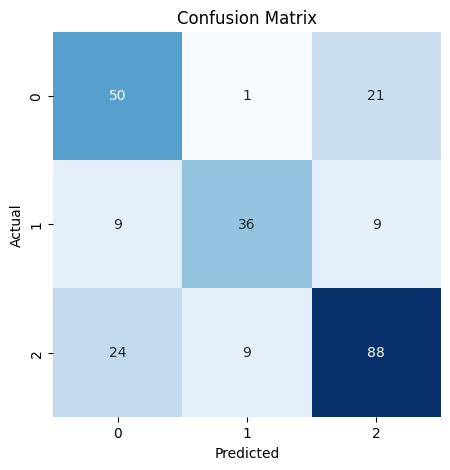

label_encoders saved successfully as label_encoders_new
XGBoost model saved successfully as xgboost_model_new.pkl


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score,confusion_matrix


trainset = pd.read_csv('/content/drive/MyDrive/playground-series-s3e22/train.csv')
trainset.columns

trainset = trainset.drop(['id','hospital_number'], axis =1)

trainset.info()

# =============================================================================
# lesion_columns = ['lesion_1', 'lesion_2', 'lesion_3']
#
# def convert_int_to_object(data, columns):
#     for column in columns:
#         if data[column].dtype == 'int64':
#             data[column] = data[column].astype('object')
#
# # Applying the function to traindata
# convert_int_to_object(trainset, lesion_columns)
# =============================================================================

trainset.isnull().sum()

trainset.dropna(inplace = True)

for i in trainset.select_dtypes(include=['object']).columns:
    print(i , ": ",trainset[i].unique())

# Convert categorical variables to numerical using LabelEncoder
label_encoders = {}
for column in trainset.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    trainset[column] = label_encoders[column].fit_transform(trainset[column])

# Split data into features and target variable
X = trainset.drop('outcome', axis=1)
y = trainset['outcome']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(set(y)), random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = xgb_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy_xgb)
print("F1-Score:",f1_xgb)
print("Classification Report:")
print(classification_report(y_test, y_pred))


# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


import pickle
import joblib
# Save the label encoders
joblib.dump(label_encoders, "label_encoders_new.pkl")
print("label_encoders saved successfully as", "label_encoders_new")


# Save the trained model to a file
filename = 'xgboost_model_new.pkl'
pickle.dump(xgb_model, open(filename, 'wb'))

print("XGBoost model saved successfully as", filename)